# Lab # 3

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import warnings
!pip install pgmpy
from pgmpy.estimators import HillClimbSearch, K2Score, BicScore, BDeuScore, BDsScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 1.9 MB 11.0 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = pd.read_csv('2015.csv')
data.head()

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


Checking null values

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Country                        158 non-null    object 
 1   Region                         158 non-null    object 
 2   Happiness Rank                 158 non-null    int64  
 3   Happiness Score                158 non-null    float64
 4   Standard Error                 158 non-null    float64
 5   Economy (GDP per Capita)       158 non-null    float64
 6   Family                         158 non-null    float64
 7   Health (Life Expectancy)       158 non-null    float64
 8   Freedom                        158 non-null    float64
 9   Trust (Government Corruption)  158 non-null    float64
 10  Generosity                     158 non-null    float64
 11  Dystopia Residual              158 non-null    float64
dtypes: float64(9), int64(1), object(2)
memory usage: 1

## Step 1. 
Choose variables for sampling from your dataset (overall – about 10 variables, 3-4 – target variables, the rest - predictors).

In [ ]:
data = data[[
             'Country',                   #vis
             'Region',                    #target
             'Happiness Rank',            #target
             'Happiness Score',           #target
             'Economy (GDP per Capita)',  #predictor
             'Family',                    #predictor
             'Health (Life Expectancy)',  #predictor
             'Freedom',                   #predictor
             'Trust (Government Corruption)',  #predictor
             'Generosity',                #predictor
             'Dystopia Residual',         #predictor
             ]]

In [ ]:
# region from text to int
region = data.Region.unique()
num = 0
for i in region:
  data['Region'] = data['Region'].replace({i:num})
  num+=1

In [ ]:
target = data[[
             'Region',                    #target
             'Happiness Rank',            #target
             'Happiness Score',           #target
             ]]
predictor = data[[
             'Economy (GDP per Capita)',  #predictor
             'Family',                    #predictor
             'Health (Life Expectancy)',  #predictor
             'Freedom',                   #predictor
             'Trust (Government Corruption)',  #predictor
             'Generosity',                #predictor
             'Dystopia Residual',         #predictor
             ]]

## Step 2. 
Using univariate parametric distributions that were fitted in Lab#2 make sampling of chosen target variables. Use for this 2 different sampling methods.

In [ ]:
sampled = data.sample(frac=0.5)
split, _ = train_test_split(data, test_size=0.5)

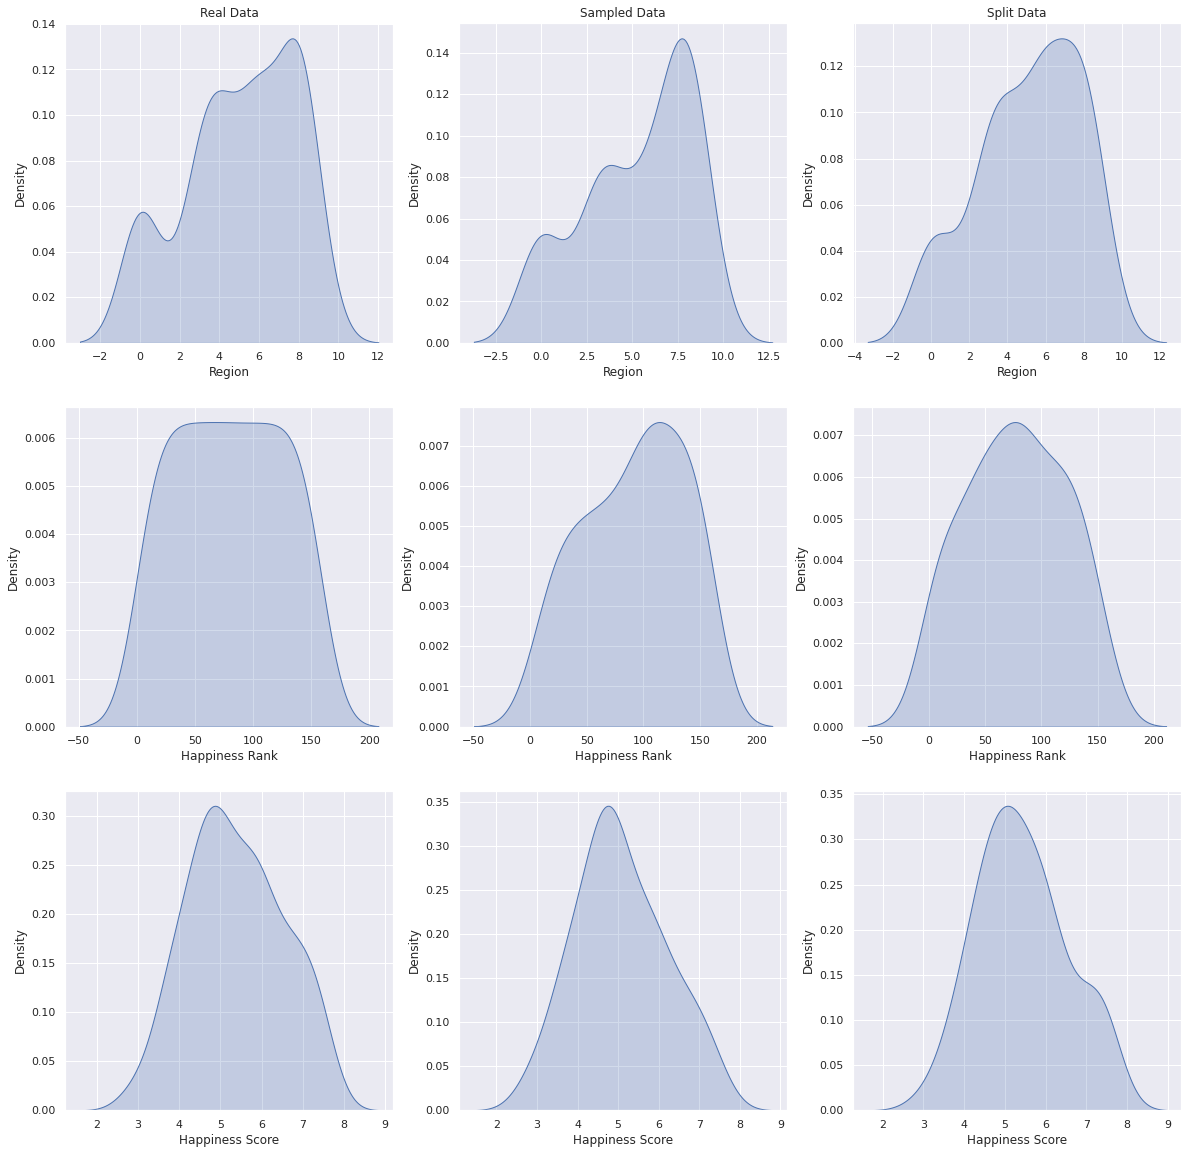

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
sns.set_theme()

ax[0, 0].set_title('Real Data')
ax[0, 1].set_title('Sampled Data')
ax[0, 2].set_title('Split Data')

sns.kdeplot(data['Region'], ax=ax[0, 0], x='Region', shade=True)
sns.kdeplot(sampled['Region'], ax=ax[0, 1], x='Region', shade=True)
sns.kdeplot(split['Region'], ax=ax[0, 2], x='Region', shade=True)

sns.kdeplot(data['Happiness Rank'], ax=ax[1, 0], x='Happiness Rank', shade=True)
sns.kdeplot(sampled['Happiness Rank'], ax=ax[1, 1], x='Happiness Rank', shade=True)
sns.kdeplot(split['Happiness Rank'], ax=ax[1, 2], x='Happiness Rank', shade=True)

sns.kdeplot(data['Happiness Score'], ax=ax[2, 0], x='Happiness Score', shade=True)
sns.kdeplot(sampled['Happiness Score'], ax=ax[2, 1], x='Happiness Score', shade=True)
sns.kdeplot(split['Happiness Score'], ax=ax[2, 2], x='Happiness Score', shade=True)

plt.show()

## Step 3.
Estimate relations between predictors and chosen target variables. At least, they should have significant correlation coefficients.

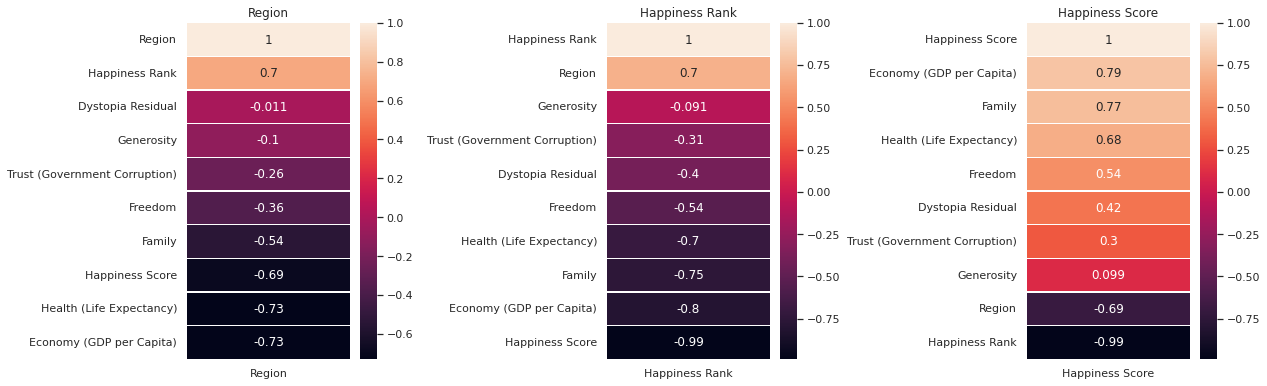

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
sns.set_theme()
fig.tight_layout(pad=15.0)

ax[0].set_title('Region')
ax[1].set_title('Happiness Rank')
ax[2].set_title('Happiness Score')

sns.heatmap(
    sampled.corr()[['Region']].sort_values(by='Region', ascending=False),
    annot=True,
    linewidths=0.25, 
    ax=ax[0]
    #x='Region'
)
sns.heatmap(
    sampled.corr()[['Happiness Rank']].sort_values(by='Happiness Rank', ascending=False),
    annot=True,
    linewidths=0.25, 
    ax=ax[1]
    #x='Region'
)
sns.heatmap(
    sampled.corr()[['Happiness Score']].sort_values(by='Happiness Score', ascending=False),
    annot=True,
    linewidths=0.25, 
    ax=ax[2]
    #x='Region'
)

plt.show()

## Step 4. 
Build a Bayesian network for chosen set of variables. Choose its structure on the basis of multivariate analysis and train distributions in nodes using chosen algorithm.

In [ ]:
transformed = sampled.copy()
discretized = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans').fit_transform(sampled.values[:, [3,4,5,6,7,8,9,10]])
transformed[['Happiness Score','Economy (GDP per Capita)','Family','Health (Life Expectancy)','Freedom','Trust (Government Corruption)','Generosity','Dystopia Residual']] = discretized

In [ ]:
hc = HillClimbSearch(data=transformed)
k2 = hc.estimate(scoring_method=K2Score(transformed))

  0%|          | 0/1000000 [00:00<?, ?it/s]

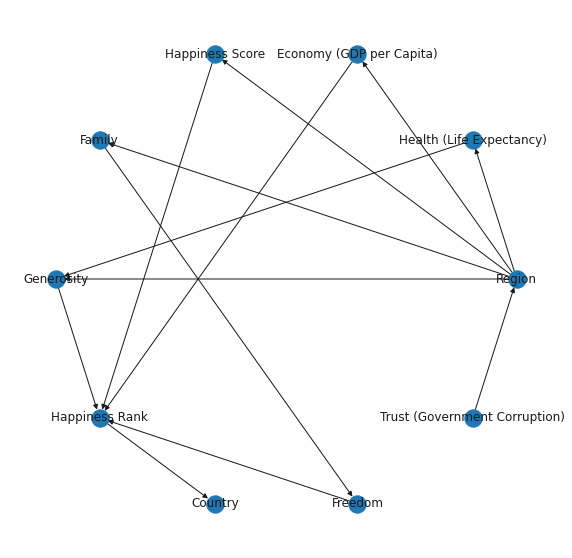

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
graph = nx.DiGraph()
graph.add_edges_from(k2.edges())
nx.draw(graph, nx.layout.circular_layout(graph), with_labels=True)
plt.show()

In [ ]:
blacklist = [(x, y) for x in transformed.columns.to_list() for y in ['Economy (GDP per Capita)','Family','Health (Life Expectancy)','Freedom','Trust (Government Corruption)','Generosity','Dystopia Residual'] if x != y]
blacklist

[('Country', 'Economy (GDP per Capita)'),
 ('Country', 'Family'),
 ('Country', 'Health (Life Expectancy)'),
 ('Country', 'Freedom'),
 ('Country', 'Trust (Government Corruption)'),
 ('Country', 'Generosity'),
 ('Country', 'Dystopia Residual'),
 ('Region', 'Economy (GDP per Capita)'),
 ('Region', 'Family'),
 ('Region', 'Health (Life Expectancy)'),
 ('Region', 'Freedom'),
 ('Region', 'Trust (Government Corruption)'),
 ('Region', 'Generosity'),
 ('Region', 'Dystopia Residual'),
 ('Happiness Rank', 'Economy (GDP per Capita)'),
 ('Happiness Rank', 'Family'),
 ('Happiness Rank', 'Health (Life Expectancy)'),
 ('Happiness Rank', 'Freedom'),
 ('Happiness Rank', 'Trust (Government Corruption)'),
 ('Happiness Rank', 'Generosity'),
 ('Happiness Rank', 'Dystopia Residual'),
 ('Happiness Score', 'Economy (GDP per Capita)'),
 ('Happiness Score', 'Family'),
 ('Happiness Score', 'Health (Life Expectancy)'),
 ('Happiness Score', 'Freedom'),
 ('Happiness Score', 'Trust (Government Corruption)'),
 ('Happin

In [ ]:
k2_bl = hc.estimate(black_list=blacklist)

  0%|          | 0/1000000 [00:00<?, ?it/s]

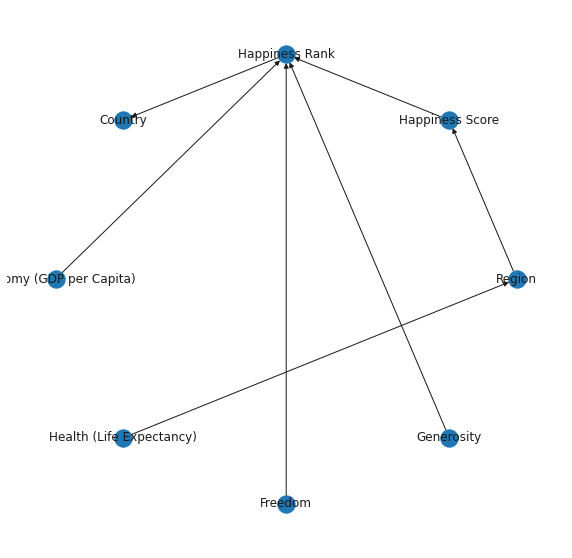

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
graph = nx.DiGraph()
graph.add_edges_from(k2_bl.edges())
nx.draw(graph, nx.layout.circular_layout(graph), with_labels=True)
plt.show()

## Step 5. 
Build a Bayesian network for the same set of variables but using 2 chosen algorithms for structural learning. 

In [ ]:
#BDeuScore
bdeu = hc.estimate(scoring_method=BDeuScore(transformed))

  0%|          | 0/1000000 [00:00<?, ?it/s]

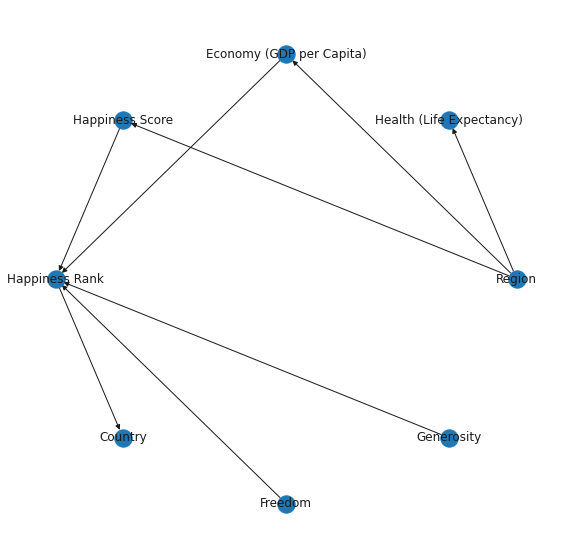

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
graph = nx.DiGraph()
graph.add_edges_from(bdeu.edges())
nx.draw(graph, nx.layout.circular_layout(graph), with_labels=True)
plt.show()

In [ ]:
#BDsScore
bds = hc.estimate(scoring_method=BDsScore(transformed))

  0%|          | 0/1000000 [00:00<?, ?it/s]

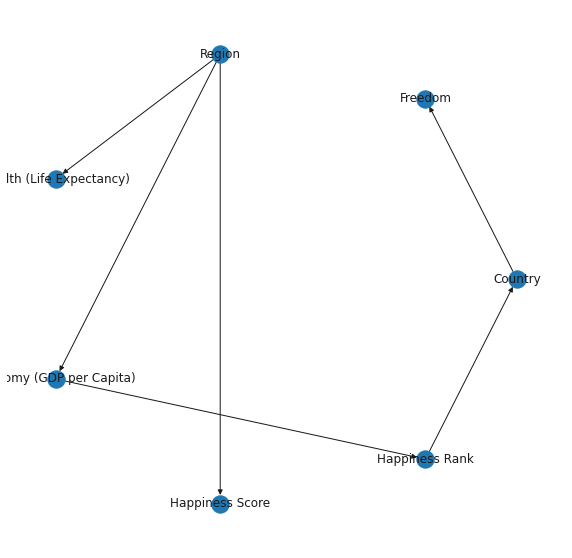

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
graph = nx.DiGraph()
graph.add_edges_from(bds.edges())
nx.draw(graph, nx.layout.circular_layout(graph), with_labels=True)
plt.show()

## Step 6. 
Analyze a quality of sampled target variables from the point of view of problem statement (e.g. prediction, gap filling, synthetic generation).

In [ ]:
def sampling(bn, data, n):
    ms = BayesianModel(bn.edges())
    ms.fit(data)
    sample = BayesianModelSampling(ms).forward_sample(size=n)
    return sample
def histplot(obj, data, s1, s2, s3, s4):
    df,df1,df2,df3,df4,df5 = pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

    df1[obj],df1['Mode'] = data[obj],'Original Data'
    df1['Prob'] = df1[obj].apply( lambda x: (df1.groupby(obj)[obj].count()[x])  /  data.shape[0])    
    df2[obj],df2['Mode']  = s1[obj],'K2Score'
    df2['Prob'] = df2[obj].apply( lambda x: (df2.groupby(obj)[obj].count()[x])  /  s1.shape[0]  )    
    df3[obj], df3['Mode'] = s2[obj],'K2 Blacklist'
    df3['Prob'] = df3[obj].apply( lambda x: (df3.groupby(obj)[obj].count()[x])  /  s2.shape[0]  )    
    df4[obj],df4['Mode'] = s3[obj],'BDeuScore'
    df4['Prob'] = df4[obj].apply( lambda x: (df4.groupby(obj)[obj].count()[x])  /  s3.shape[0]  )    
    df5[obj],df5['Mode'] = s4[obj],'BDsScore'
    df5['Prob'] = df5[obj].apply( lambda x: (df5.groupby(obj)[obj].count()[x])  /  s4.shape[0]  )

    df = pd.concat([df1, df2, df3, df4, df5])    
    figure, ax = plt.subplots(1, 1, figsize=(40, 10))
    sns.set_theme()
    sns.barplot(x=obj, y='Prob', hue='Mode', data=df)    
    plt.legend()
    plt.show()

In [ ]:
s1=sampling(k2, transformed, 79)[:79]
s2=sampling(k2_bl, transformed, 79)[:79]
s3=sampling(bdeu, transformed, 79)[:79]
s4=sampling(bds, transformed, 79)[:79]

/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  FutureWarning,


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pgmpy/utils/mathext.py:84: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  f"Probability values don't exactly sum to 1. Differ by: {error}. Adjusting values."
/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  FutureWarning,


  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pgmpy/utils/mathext.py:84: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  f"Probability values don't exactly sum to 1. Differ by: {error}. Adjusting values."
/usr/local/lib/python3.7/dist-packages/pgmpy/utils/mathext.py:84: UserWarning: Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
  f"Probability values don't exactly sum to 1. Differ by: {error}. Adjusting values."
/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  FutureWarning,


  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pgmpy/utils/mathext.py:84: UserWarning: Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
  f"Probability values don't exactly sum to 1. Differ by: {error}. Adjusting values."
/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  FutureWarning,


  0%|          | 0/7 [00:00<?, ?it/s]

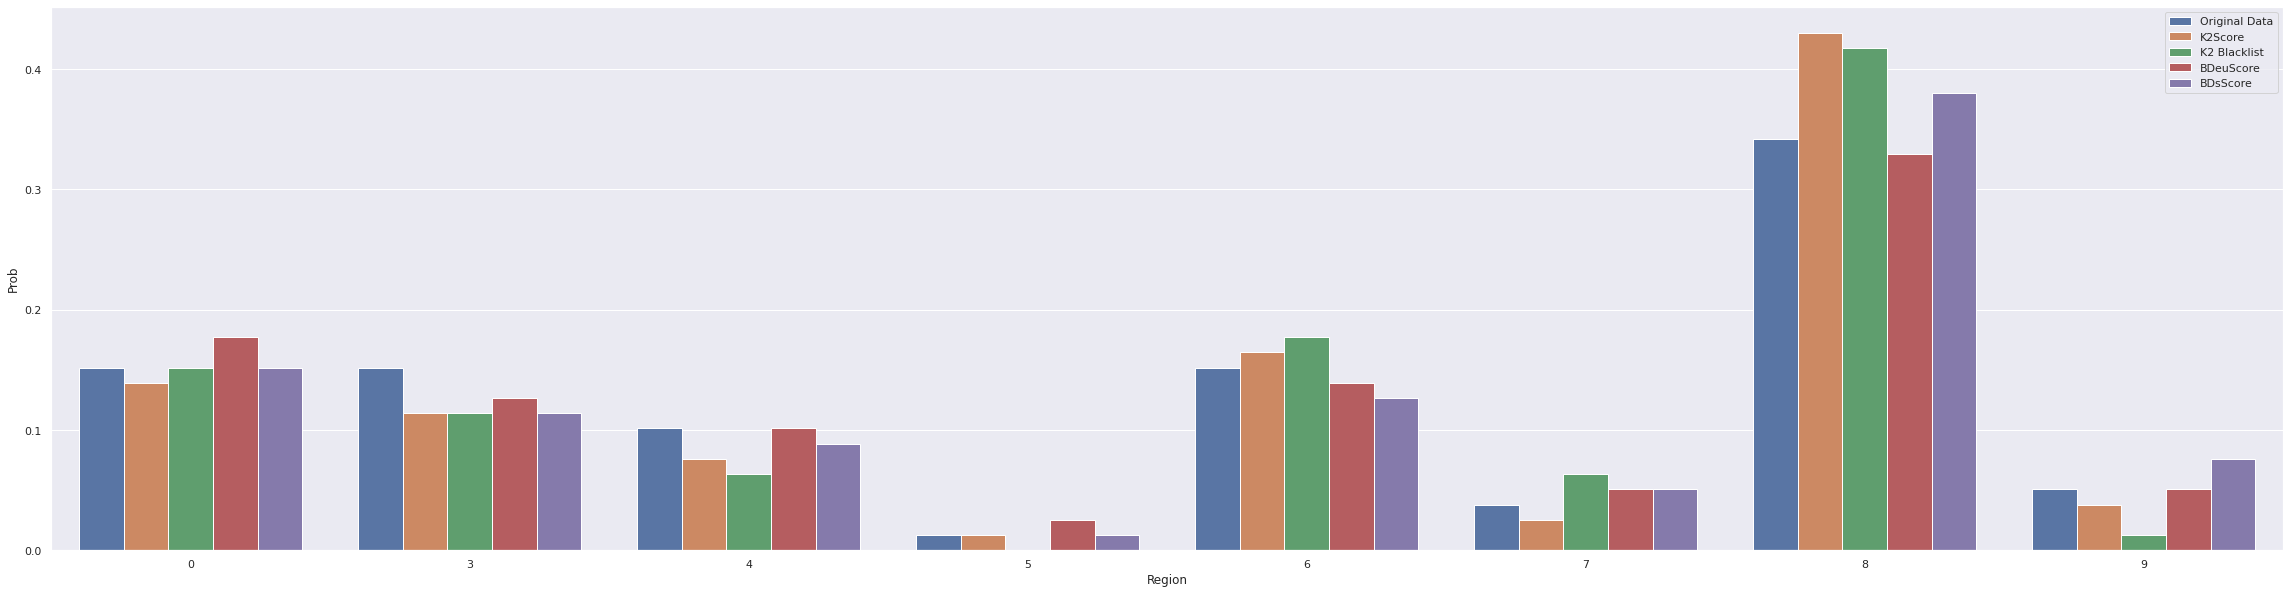

In [ ]:
histplot('Region',transformed,s1,s2,s3,s4)

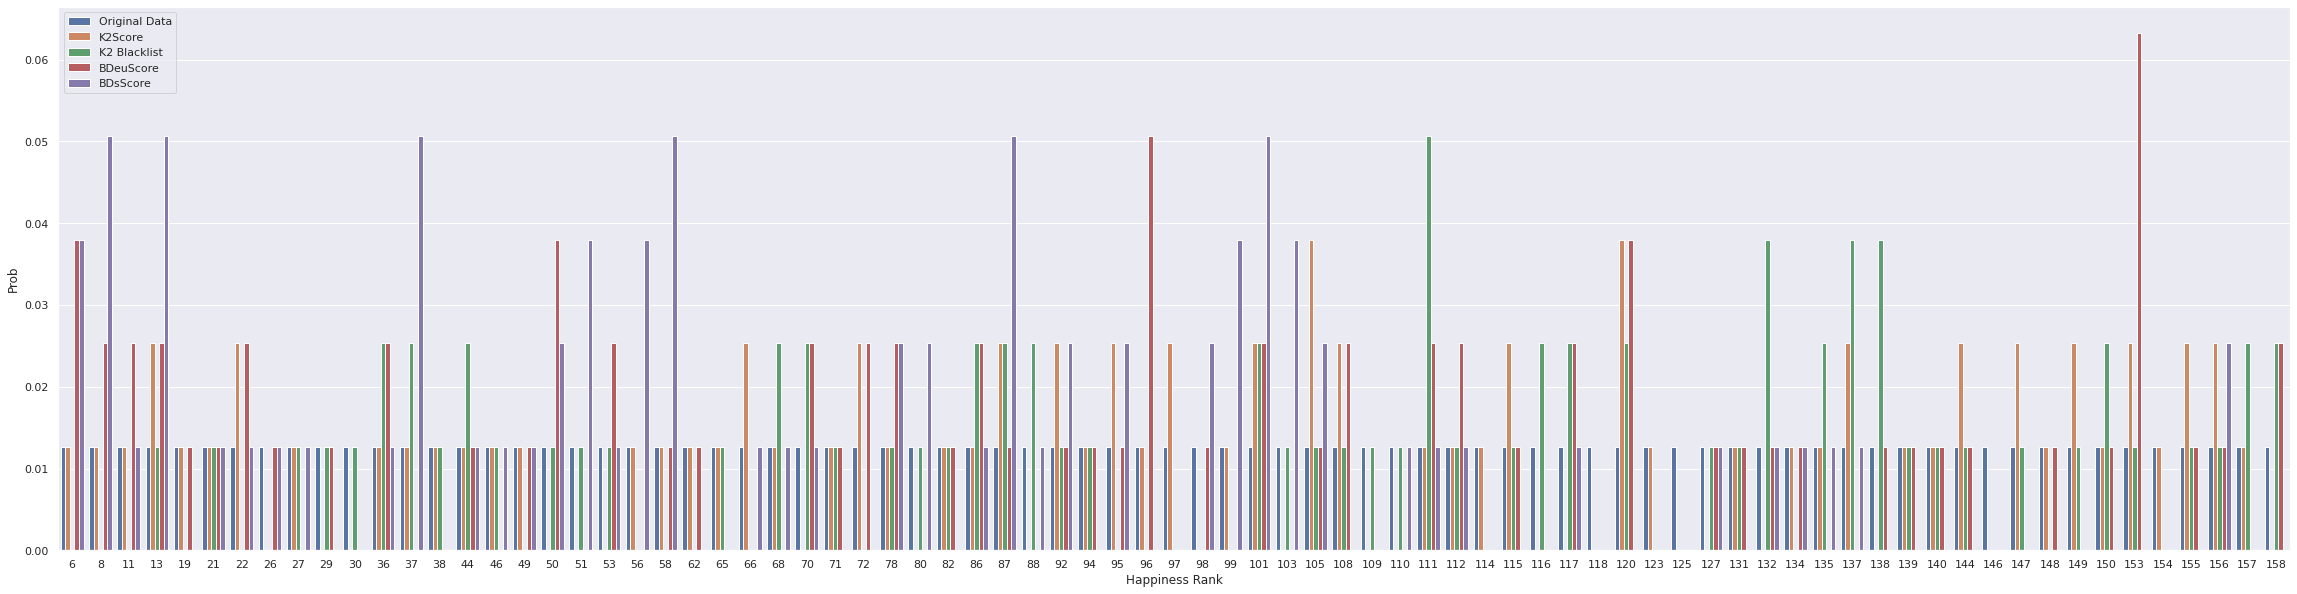

In [ ]:
histplot('Happiness Rank',transformed,s1,s2,s3,s4)

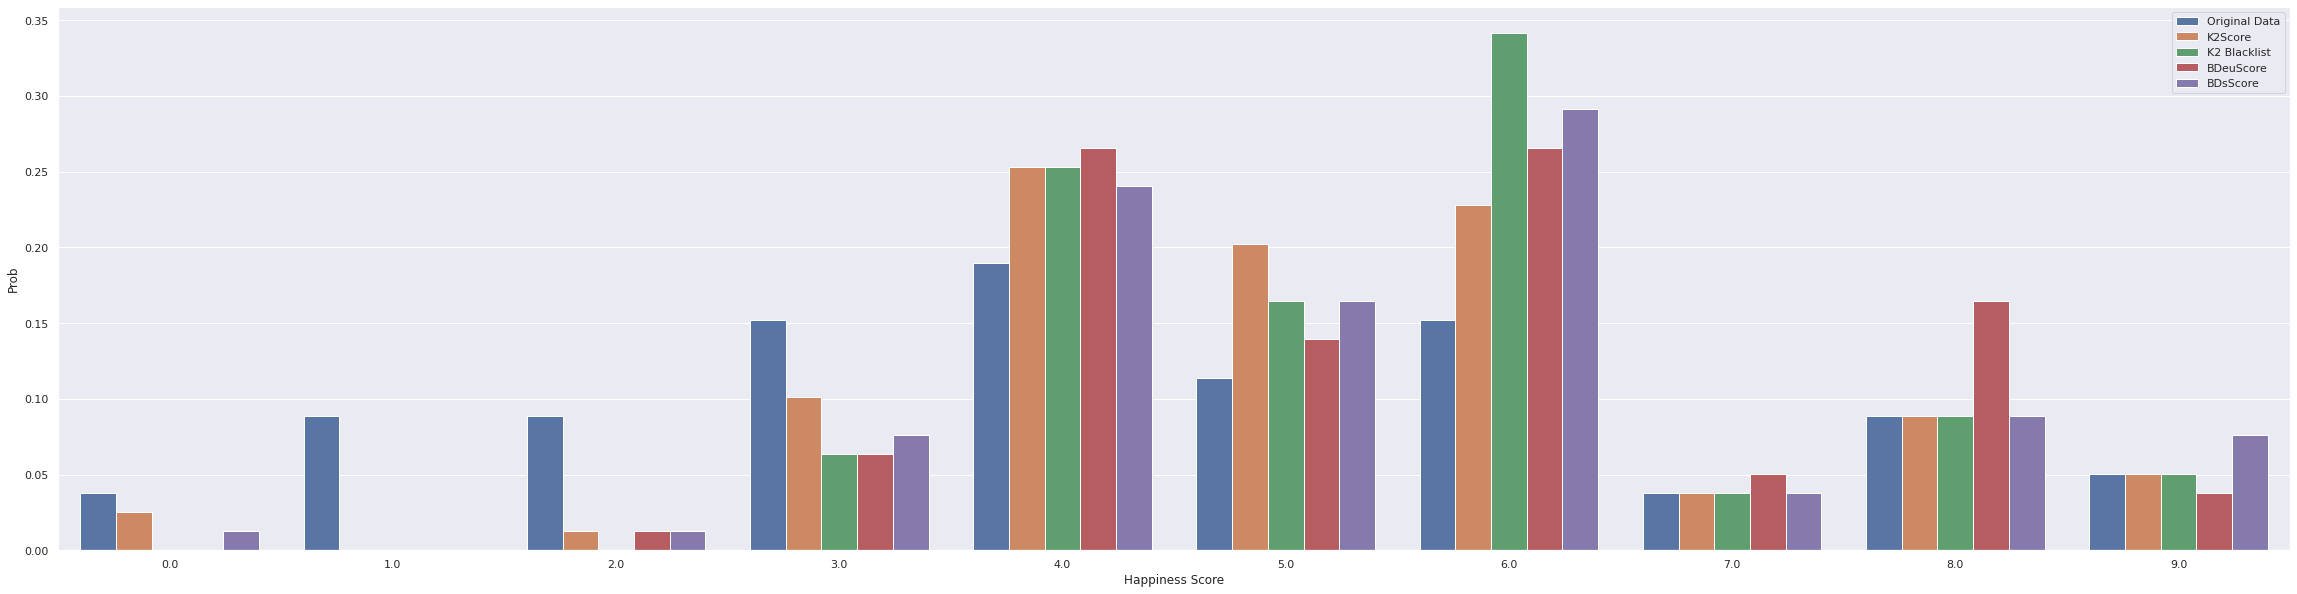

In [ ]:
histplot('Happiness Score',transformed,s1,s2,s3,s4)